In [1]:
import keras

Using TensorFlow backend.


In [2]:
from keras.layers import Activation, Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras import regularizers
from keras.models import Model, Sequential
#from Models.functions.preprocessing import clean
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
import numpy as np
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
import itertools

In [3]:
def create_model(filters = [100], kernel_size = [50], strides = [100], dropout_rate = [0.5], pool_size = [5]):

    model = Sequential()

    # conv 1
    model.add(Conv1D(filters = filters[0], 
                     kernel_size = kernel_size[0],
                     strides = strides[0], 
                     activation = 'relu', 
                     input_shape = (20000, 1) ))

    # pooling layer 1
    model.add(MaxPooling1D(pool_size = pool_size[0], strides = 1))
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dense(units = 100, activation = 'relu'))
    model.add(Dense(units = 2, activation = 'softmax'))

    model.compile(optimizer = 'adadelta', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [4]:
import pandas as pd
result = pd.DataFrame()

def get_results(model):

    config = model.get_config()

    row = {}

    conv_layers = np.sum([1 if i['class_name'] == "Conv1D" else 0 for i in config])
    pooling_layers = np.sum([1 if i['class_name'] == "MaxPooling1D" else 0 for i in config])

    row.update({ '_accuracy': accuracy_score(y_espected, y_predicted) })
    row.update({ '_f1-score': f1_score(y_espected, y_predicted,average='weighted')})
    row.update({ 'conv_layers': conv_layers })
    row.update({ 'pooling_layers': pooling_layers })

    _, _, fscore, support = precision_recall_fscore_support(y_espected, y_predicted)

    [row.update({'_fscore_class_'+str(i[0]): i[1]}) for i in enumerate(fscore)]
    [row.update({'_support_class_'+str(i[0]): i[1]}) for i in enumerate(support)]

    idx = 1
    for i in config:
        if i['class_name'] == "Conv1D":
            j = str(idx)
            row.update({
                'filters_'+j: i['config']['filters'],
                'strides_'+j: i['config']['strides'],
                'kernel_size_'+j: i['config']['kernel_size'],
                'activation_'+j: i['config']['activation']
            })
        pass
    return row

In [5]:
def labelEncoder(y):
    le = preprocessing.LabelEncoder()
    le.fit(y)
    return (le.transform(y), len(le.classes_), list(le.classes_))

from sklearn.feature_extraction.text import TfidfVectorizer


In [6]:
from Models.functions.datasets import loadTrainTest
X_train, X_test, y_train, y_test = loadTrainTest("gender", "b5post", "/home/rafael/GDrive/Data/Dataframe/")

y_train, n, _ = labelEncoder(y_train)
y_test, n, classes_names = labelEncoder(y_test)

X = np.concatenate([X_train, X_test])

vect = TfidfVectorizer()

vect.fit(X)

y_train.shape, X_train.shape

((815,), (815,))

In [7]:
from gensim.models import KeyedVectors
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument

In [8]:
max_length = np.max([len(x.split(" ")) for x in X_train])
mean_length = np.mean([len(x.split(" ")) for x in X_train])
mediam_length = np.median([len(x.split(" ")) for x in X_train])

print(max_length, mean_length, mediam_length, int(mediam_length), int(mediam_length) == 2255)

26911 2896.267484662577 2255.0 2255 True


In [ ]:
from keras.preprocessing.sequence import pad_sequences

#w2v_path = '/home/rafael/GDrive/Data/Embeddings/skip_s100.txt'
try:
    if len(embeddings_index) < 2:
        embeddings_index = None
except:
    embeddings_index = None    
    
if embeddings_index is None:
    embeddings_index = {}        
    f = open(r'/home/rafael/GDrive/Data/Embeddings/skip_s100.txt', encoding='utf8')
    c = 0
    for line in f:
        values = line.split()


        word = values[0]

        #print(word, values[1:])
        try:
            coefs = np.asarray(values[1:], dtype='float32')

            embeddings_index[word] = coefs
        except:
            pass

    print('Found %s word embedding' % len(embeddings_index))
    f.close()

embedding_matrix = np.zeros((len(vect.get_feature_names()), 100))
print("weights", len(embedding_matrix))

X_matrix = []
y_matrix = []

j = 0
for j in range(len(X_train)):
    instancia = X_train[j]
    rows = []
    tokens = instancia.split(" ")
    limit = 0    
    
    #n_tokens = len(tokens)    
    n_tokens = int(mediam_length)
    
    i = 0
    idx = 0
    while i < n_tokens:  
        
        try:
            palavra = tokens[idx]
        except:
            palavra = None
        
        #print(palavra, tokens[idx])
        
        if palavra is None: 
            idx += 1
            continue
        
        if len(tokens) < i:
            w = np.zeros(100)
        else:
            w = embeddings_index.get(str(palavra).lower())
            
        if w is None: 
            idx += 1
            continue
        
        idx += 1
        i += 1        
        rows.append(w)

    y_matrix.append( y_train[j] )    
    X_matrix.append(rows)

X_matrix, y_matrix = np.array(X_matrix), np.array(y_matrix)

X_matrix.shape, y_matrix.shape

Found 929595 word embedding
weights 83585


In [ ]:
X_train.shape, y_train.shape

In [ ]:
X_reduced = np.array([np.concatenate([X_matrix[i][j] for j in range(len(X_matrix[i]))]) for i in range(len(X_matrix))])
X_reduced.shape, y_matrix.shape

### Normalizer

In [17]:
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Synthetic Minority Oversampling Technique (SMOTE)
def oversampling(X, y):
    X_resampled, y_resampled = SMOTE().fit_resample(X, y)
    return X_resampled, y_resampled

X_resampled, y_resampled = oversampling(X_reduced, y_matrix)

#scaler = StandardScaler().fit(X)
#m = scaler.transform(X)
#m = matrix2

### Split train and test

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


from keras.utils import to_categorical
#y_train = to_categorical(y_train, 2)
#y_test = to_categorical(y_test, 2)
print(len(y_train), len(x_train))
print(len(y_test), len(x_test))
#print()
#print(y_test)

x_test.shape, x_train.shape

(710, 20000) (178, 20000) (710,) (178,)
710 710
178 178


((178, 20000, 1), (710, 20000, 1))

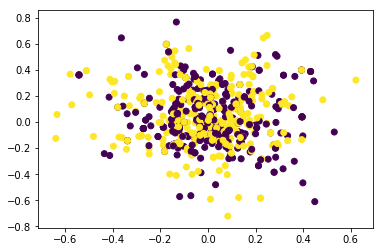

In [24]:
xid, yid = 1, 2
plt.scatter(x_train[:,xid], x_train[:,yid],c=y_train)
#plt.ylabel(classes_names[0])
#plt.ylabel(classes_names[1])

In [862]:
from time import time

CNN = KerasClassifier(build_fn=create_model, 
                epochs=1,
                #batch_size=BATCH_SIZE,
                verbose=0,
                validation_split=0.1
                )

params_grid = dict(
        filters = [[40]],
        kernel_size = [[50]],
        strides = [[100]],
        dropout_rate = [[0.5]],
        pool_size = [[5]],
        epochs = [1]
        #batch_size = 100
)                               

grid_search = GridSearchCV(CNN, 
                           params_grid, 
                           scoring='accuracy', cv=3, 
                           return_train_score=True
                           )

#print('best params', grid_search.best_params_)


print("Performing grid search...")    
t0 = time()

#histories = []
grid_results = grid_search.fit(x_train,y_train)

print("done in %0.2fs and %0.1fmin" % ((time() - t0), ((time() - t0) / 60) ))
print()

print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
display(pd.DataFrame(grid_search.cv_results_))

Performing grid search...
done in 12.87s and 0.2min

Parameters of the best model: 
{'filters': [40], 'dropout_rate': [0.5], 'kernel_size': [50], 'epochs': 1, 'strides': [100], 'pool_size': [5]}
Best parameters set:
	dropout_rate: [0.5]
	epochs: 1
	filters: [40]
	kernel_size: [50]
	pool_size: [5]
	strides: [100]


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_dropout_rate,param_epochs,param_filters,param_kernel_size,param_pool_size,param_strides,...,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,2.563522,0.806199,0.525352,0.541501,[0.5],1,[40],[50],[5],[100],...,0.493671,0.490486,0.476793,0.524313,0.605932,0.609705,0.027352,0.012802,0.057275,0.050165


{'build_fn': <function __main__.create_model(filters=[100], kernel_size=[50], strides=[100], dropout_rate=[0.5], pool_size=[5])>,
 'dropout_rate': [0.5],
 'epochs': 1,
 'filters': [40],
 'kernel_size': [50],
 'pool_size': [5],
 'strides': [100],
 'validation_split': 0.1,
 'verbose': 0}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_131 (Conv1D)          (None, 200, 40)           2040      
_________________________________________________________________
max_pooling1d_124 (MaxPoolin (None, 196, 40)           0         
_________________________________________________________________
activation_66 (Activation)   (None, 196, 40)           0         
_________________________________________________________________
flatten_118 (Flatten)        (None, 7840)              0         
_________________________________________________________________
dense_203 (Dense)            (None, 100)               784100    
_________________________________________________________________
dense_204 (Dense)            (None, 2)                 202       
Total params: 786,342
Trainable params: 786,342
Non-trainable params: 0
_________________________________________________________________


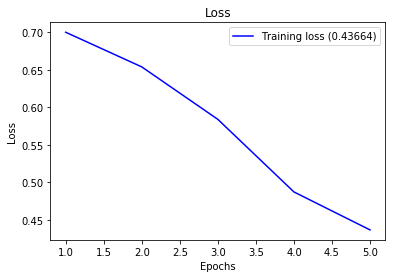

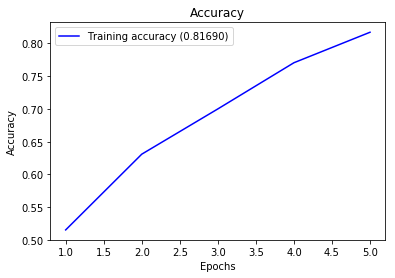

Accuracy : 0.6460674157303371

Classification Report
              precision    recall  f1-score   support

           0    0.57042   0.97590   0.72000        83
           1    0.94444   0.35789   0.51908        95

   micro avg    0.64607   0.64607   0.64607       178
   macro avg    0.75743   0.66690   0.61954       178
weighted avg    0.77004   0.64607   0.61277       178

[[81  2]
 [61 34]]


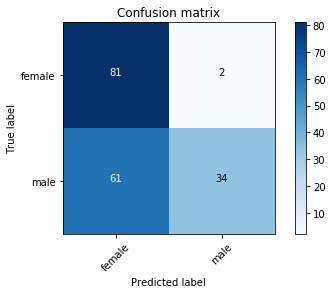

In [883]:
params = best_parameters

## create the model with the best params found
model = create_model(filters=params['filters'],
                     kernel_size=params['kernel_size'],
                     strides=params['strides'],
                     dropout_rate=params['dropout_rate'],
                     pool_size=params['pool_size']
                    )

## Then train it and display the results
history = model.fit(x_train,
                    y_train,
                    epochs=5,#params['epochs'],
                    #batch_size=params['batch_size'],
                    verbose = 0)

model.summary()

plot_history(history)


full_multiclass_report(model,
                       x_test,
                       y_test,
                       classes=classes_names
                      )
                       #batch_size=32,
                       #binary= )